In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import json


# Overview

Due to the complexity of the model, we fitted LSTM with regularization. 

We use MSE as loss function while keeping track of training weighted R square and validation R square.

We found out that LSTM works pretty well with the data. Comparing to the leaderboard on Kaggle, 0.006 is a good performance.

We tried 3 structure

# Reference
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

https://www.kaggle.com/code/tarriaza/basic-pytorch-lstm

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [2]:
df = pd.read_csv("df_miss_outliers_replaced_scaled_normalized.csv")

In [3]:
features = df[[f"feature_{i:02}" for i in range(79)]].values
target = df['responder_6'].values
weights = df['weight'].values

In [4]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    features, target, weights, test_size=0.2, random_state=42
)

In [5]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.unsqueeze(1)
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get the last time step's output
        return out


In [6]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
w_train_tensor = torch.tensor(w_train, dtype=torch.float32).view(-1,1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)
w_val_tensor = torch.tensor(w_val, dtype=torch.float32).view(-1,1)

In [7]:
# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, w_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor, w_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20

In [9]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # L2 regularization

In [10]:
result = {'train_loss': [], 'train_w_r2': [], 'val_loss': [], 'val_w_r2': []}

In [13]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (inputs, targets, weights) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets, weights in val_loader:
            outputs = model(inputs)
            loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
            val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        y_train_pred = model(X_train_tensor).detach().numpy().reshape(-1)
        y_val_pred = model(X_val_tensor).detach().numpy().reshape(-1)

        train_w_r2 = r2_score(y_train, y_train_pred, sample_weight=w_train)
        val_w_r2 = r2_score(y_val, y_val_pred, sample_weight=w_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train wR^2: {train_w_r2:.4f}, Val Loss: {val_loss:.4f}, Val wR^2: {val_w_r2:.4f}')

        result['train_loss'].append(train_loss)
        result['train_w_r2'].append(train_w_r2)
        result['val_loss'].append(val_loss)
        result['val_w_r2'].append(val_w_r2)


Epoch [1/20], Train Loss: 1.5805, Train wR^2: 0.0028, Val Loss: 1.6041, Val wR^2: 0.0027
Epoch [2/20], Train Loss: 1.5815, Train wR^2: 0.0051, Val Loss: 1.5998, Val wR^2: 0.0051
Epoch [3/20], Train Loss: 1.5820, Train wR^2: 0.0054, Val Loss: 1.5996, Val wR^2: 0.0055
Epoch [4/20], Train Loss: 1.5819, Train wR^2: 0.0053, Val Loss: 1.5994, Val wR^2: 0.0052
Epoch [5/20], Train Loss: 1.5798, Train wR^2: 0.0054, Val Loss: 1.5991, Val wR^2: 0.0054
Epoch [6/20], Train Loss: 1.5815, Train wR^2: 0.0060, Val Loss: 1.5985, Val wR^2: 0.0059
Epoch [7/20], Train Loss: 1.5800, Train wR^2: 0.0045, Val Loss: 1.6015, Val wR^2: 0.0044
Epoch [8/20], Train Loss: 1.5797, Train wR^2: 0.0057, Val Loss: 1.5994, Val wR^2: 0.0055
Epoch [9/20], Train Loss: 1.5819, Train wR^2: 0.0060, Val Loss: 1.5987, Val wR^2: 0.0057
Epoch [10/20], Train Loss: 1.5793, Train wR^2: 0.0046, Val Loss: 1.6001, Val wR^2: 0.0044
Epoch [11/20], Train Loss: 1.5790, Train wR^2: 0.0053, Val Loss: 1.5996, Val wR^2: 0.0048
Epoch [12/20], Trai

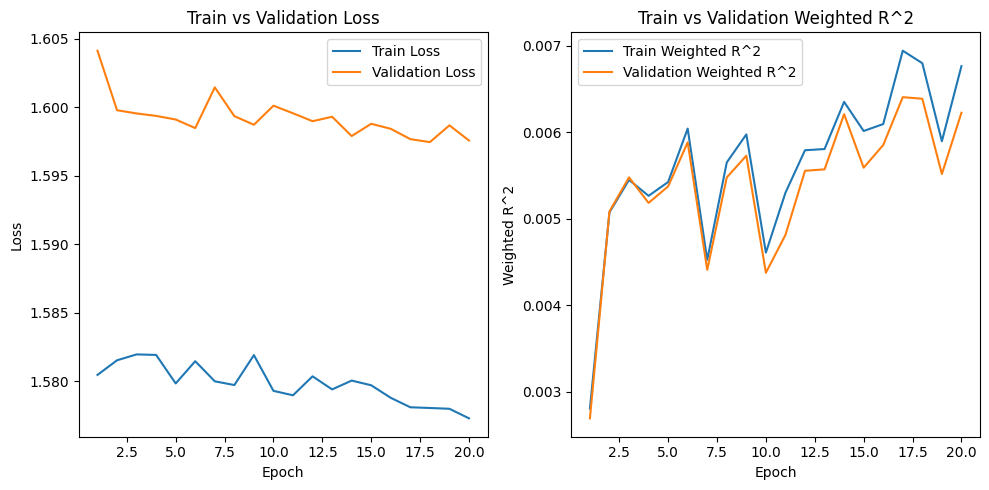

In [20]:
epochs_plt = range(1, len(result['train_loss']) + 1, 1)

# Plotting Loss (Train and Validation)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs_plt, result['train_loss'], label='Train Loss')
plt.plot(epochs_plt, result['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Weighted R^2 (Train and Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs_plt, result['train_w_r2'], label='Train Weighted R^2')
plt.plot(epochs_plt, result['val_w_r2'], label='Validation Weighted R^2')
plt.title('Train vs Validation Weighted R^2')
plt.xlabel('Epoch')
plt.ylabel('Weighted R^2')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
epochs_plt

range(1, 21)

In [24]:
with open('lstm1.json', 'w') as file:
    json.dump(result, file)

In [25]:
result = {'train_loss': [], 'train_w_r2': [], 'val_loss': [], 'val_w_r2': []}

In [26]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
num_layers = 3
output_size = 1
learning_rate = 0.001
num_epochs = 20

In [27]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # L2 regularization

In [28]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (inputs, targets, weights) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets, weights in val_loader:
            outputs = model(inputs)
            loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
            val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        y_train_pred = model(X_train_tensor).detach().numpy().reshape(-1)
        y_val_pred = model(X_val_tensor).detach().numpy().reshape(-1)

        train_w_r2 = r2_score(y_train, y_train_pred, sample_weight=w_train)
        val_w_r2 = r2_score(y_val, y_val_pred, sample_weight=w_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train wR^2: {train_w_r2:.4f}, Val Loss: {val_loss:.4f}, Val wR^2: {val_w_r2:.4f}')

        result['train_loss'].append(train_loss)
        result['train_w_r2'].append(train_w_r2)
        result['val_loss'].append(val_loss)
        result['val_w_r2'].append(val_w_r2)


Epoch [1/20], Train Loss: 1.5875, Train wR^2: -0.0000, Val Loss: 1.6086, Val wR^2: -0.0001
Epoch [2/20], Train Loss: 1.5884, Train wR^2: -0.0000, Val Loss: 1.6084, Val wR^2: -0.0000
Epoch [3/20], Train Loss: 1.5876, Train wR^2: -0.0000, Val Loss: 1.6084, Val wR^2: -0.0000
Epoch [4/20], Train Loss: 1.5888, Train wR^2: -0.0000, Val Loss: 1.6085, Val wR^2: -0.0001
Epoch [5/20], Train Loss: 1.5882, Train wR^2: -0.0001, Val Loss: 1.6083, Val wR^2: -0.0000
Epoch [6/20], Train Loss: 1.5880, Train wR^2: 0.0000, Val Loss: 1.6084, Val wR^2: -0.0000
Epoch [7/20], Train Loss: 1.5887, Train wR^2: -0.0003, Val Loss: 1.6091, Val wR^2: -0.0004
Epoch [8/20], Train Loss: 1.5878, Train wR^2: -0.0003, Val Loss: 1.6085, Val wR^2: -0.0002
Epoch [9/20], Train Loss: 1.5869, Train wR^2: -0.0002, Val Loss: 1.6084, Val wR^2: -0.0001
Epoch [10/20], Train Loss: 1.5881, Train wR^2: -0.0001, Val Loss: 1.6086, Val wR^2: -0.0001
Epoch [11/20], Train Loss: 1.5883, Train wR^2: -0.0000, Val Loss: 1.6085, Val wR^2: -0.000

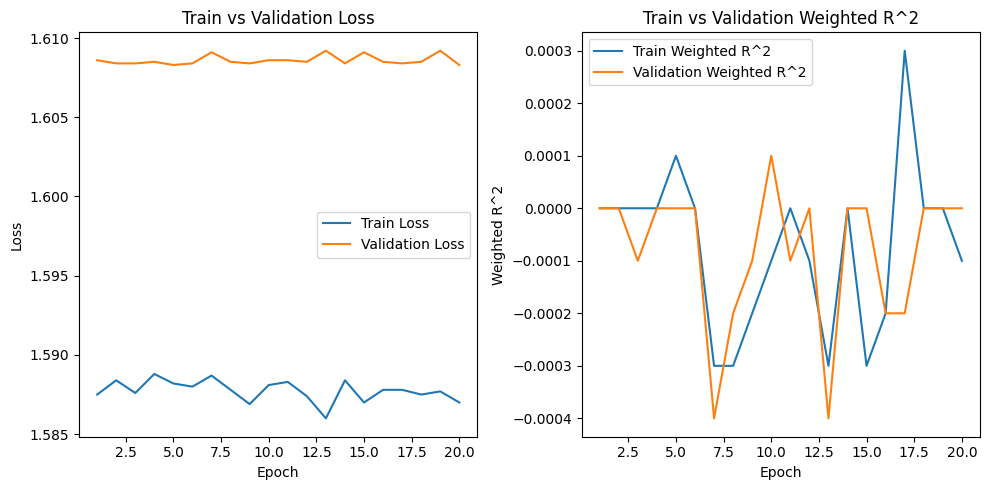

In [4]:
epochs_plt = range(1, len(result['train_loss']) + 1, 1)

# Plotting Loss (Train and Validation)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs_plt, result['train_loss'], label='Train Loss')
plt.plot(epochs_plt, result['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Weighted R^2 (Train and Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs_plt, result['train_w_r2'], label='Train Weighted R^2')
plt.plot(epochs_plt, result['val_w_r2'], label='Validation Weighted R^2')
plt.title('Train vs Validation Weighted R^2')
plt.xlabel('Epoch')
plt.ylabel('Weighted R^2')
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
result = {'train_loss': [], 'train_w_r2': [], 'val_loss': [], 'val_w_r2': []}

In [9]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 32
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 20

In [10]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) # L2 regularization

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [11]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (inputs, targets, weights) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets, weights in val_loader:
            outputs = model(inputs)
            loss = (criterion(outputs, targets) * weights).mean()  # Apply weighted loss
            val_losses.append(loss.item())

        val_loss = np.mean(val_losses)
        y_train_pred = model(X_train_tensor).detach().numpy().reshape(-1)
        y_val_pred = model(X_val_tensor).detach().numpy().reshape(-1)

        train_w_r2 = r2_score(y_train, y_train_pred, sample_weight=w_train)
        val_w_r2 = r2_score(y_val, y_val_pred, sample_weight=w_val)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train wR^2: {train_w_r2:.4f}, Val Loss: {val_loss:.4f}, Val wR^2: {val_w_r2:.4f}')

        result['train_loss'].append(train_loss)
        result['train_w_r2'].append(train_w_r2)
        result['val_loss'].append(val_loss)
        result['val_w_r2'].append(val_w_r2)


Epoch [1/20], Train Loss: 1.5864, Train wR^2: 0.0036, Val Loss: 1.6029, Val wR^2: 0.0035
Epoch [2/20], Train Loss: 1.5820, Train wR^2: 0.0016, Val Loss: 1.6038, Val wR^2: 0.0017
Epoch [3/20], Train Loss: 1.5819, Train wR^2: 0.0052, Val Loss: 1.6000, Val wR^2: 0.0050
Epoch [4/20], Train Loss: 1.5802, Train wR^2: 0.0027, Val Loss: 1.6044, Val wR^2: 0.0023
Epoch [5/20], Train Loss: 1.5799, Train wR^2: 0.0040, Val Loss: 1.6008, Val wR^2: 0.0040
Epoch [6/20], Train Loss: 1.5791, Train wR^2: 0.0051, Val Loss: 1.5998, Val wR^2: 0.0047
Epoch [7/20], Train Loss: 1.5781, Train wR^2: 0.0062, Val Loss: 1.5982, Val wR^2: 0.0058
Epoch [8/20], Train Loss: 1.5787, Train wR^2: 0.0066, Val Loss: 1.5981, Val wR^2: 0.0061
Epoch [9/20], Train Loss: 1.5767, Train wR^2: 0.0056, Val Loss: 1.5998, Val wR^2: 0.0049
Epoch [10/20], Train Loss: 1.5781, Train wR^2: 0.0073, Val Loss: 1.5976, Val wR^2: 0.0065
Epoch [11/20], Train Loss: 1.5761, Train wR^2: 0.0074, Val Loss: 1.5975, Val wR^2: 0.0063
Epoch [12/20], Trai

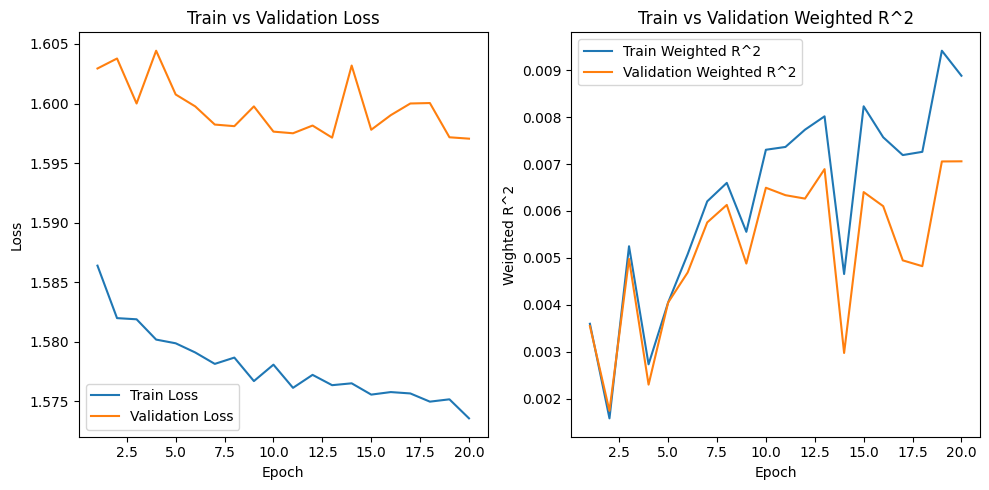

In [12]:
epochs_plt = range(1, len(result['train_loss']) + 1, 1)

# Plotting Loss (Train and Validation)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs_plt, result['train_loss'], label='Train Loss')
plt.plot(epochs_plt, result['val_loss'], label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting Weighted R^2 (Train and Validation)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs_plt, result['train_w_r2'], label='Train Weighted R^2')
plt.plot(epochs_plt, result['val_w_r2'], label='Validation Weighted R^2')
plt.title('Train vs Validation Weighted R^2')
plt.xlabel('Epoch')
plt.ylabel('Weighted R^2')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
with open('lstm2.json', 'w') as file:
    json.dump(result, file)